# ⚙️ Preprocessing and Baseline Model

### Tasks
- 📂 **Split the dataset** into training and testing sets  
- 🛠️ **Preprocess data** using **scikit-learn pipelines**  
- 🤖 **Train the baseline model (Logistic regression)**  
- 📊 **Evaluate model performance**  


In [40]:
# imports 
import pandas as pd
import os 
import sys
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))
from src.data_loader import load_data, load_data_from_file
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.model_selection import (
    cross_validate,
    cross_val_score,
    KFold,
    StratifiedKFold,
)
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)


### Data import 

In [3]:
location = '../data/raw/'
df = load_data_from_file(file_path=os.path.join(location, 'SantanderCustomerSatisfaction.csv'))

Loading dataset from file: ../data/raw/SantanderCustomerSatisfaction.csv...


In [4]:
def tweak_df(df):
    df = df.copy()
    df['target'] = df['target'].astype('category')
    return df

In [5]:
df = tweak_df(df)

### Train Test split

In [7]:
(
    df_train,
    df_test,
    y_train,
    y_test,
) = train_test_split(
    df.drop(columns=['target']),
    df['target'],
    test_size=0.2,
    random_state=42,
    stratify=df['target'],
)

Text(0.5, 1.0, 'Test distribution')

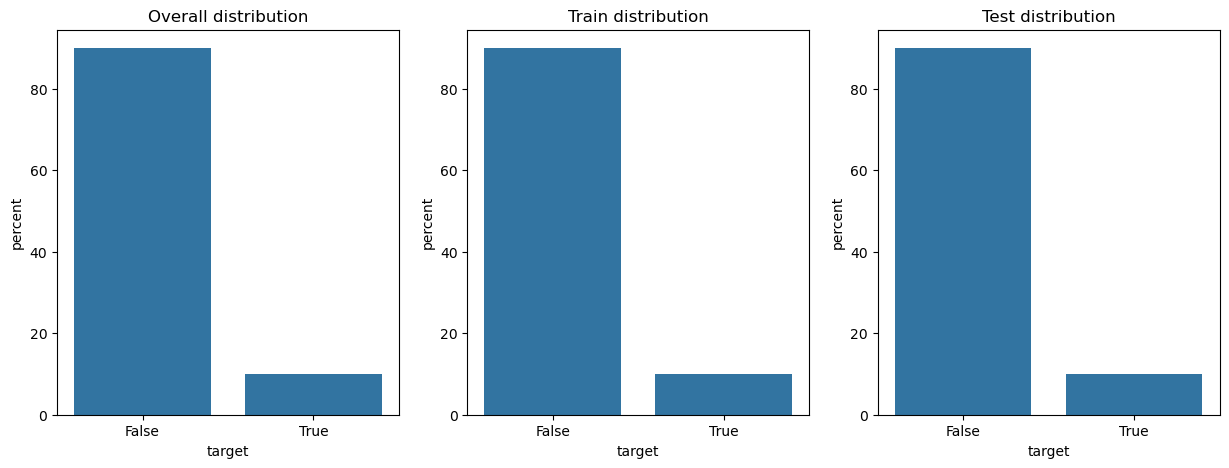

In [14]:
fig , ax = plt.subplots(1,3, figsize=(15,5))
sns.countplot(x=df['target'],stat='percent',ax=ax[0]).set_title('Overall distribution')
sns.countplot(x=y_train,stat='percent',ax=ax[1]).set_title('Train distribution')
sns.countplot(x=y_test,stat='percent',ax=ax[2]).set_title('Test distribution')

💡 **Note on Preprocessing**  

Since the dataset contains **only numerical columns** with **no missing values**, the preprocessing step is fairly minimal.  
The main consideration is selecting an appropriate **scaling strategy** for the machine learning model.  


In [26]:
def get_preprocessor(scaler, df):
    return make_column_transformer(
        (scaler, df.columns),
        verbose_feature_names_out=True,
    ).set_output(transform="pandas")

lr_preprocessor_std = get_preprocessor(StandardScaler(), df_train)
lr_preprocessor_minmax = get_preprocessor(MinMaxScaler(), df_train)

### Logistic regression

In [27]:
def get_lr_pipeline(preprocessor):
    return make_pipeline(
        preprocessor,
        LogisticRegression(random_state=42, max_iter=1000)
    )
lr_pipeline_std = get_lr_pipeline(lr_preprocessor_std)
lr_pipeline_minmax = get_lr_pipeline(lr_preprocessor_minmax)

#### Defining cross validation setup

In [44]:
def run_cv(estimator, X, y, cv, verbose=2):
    return cross_validate(
        estimator=estimator,
        X=X,
        y=y,
        cv=cv,
        scoring=("roc_auc", "average_precision"),
        return_estimator=True,
        return_indices=True,
        return_train_score=True,
        verbose=verbose,
    )
    
def print_test_scores(cv_results, scorings=("test_roc_auc", "test_average_precision")):
    for score in scorings:
        print(
            f"mean {score:30s} score = {cv_results[score].mean():.5f} +/- {cv_results[score].std():.5f}"
        )
    

In [ ]:
cv = StratifiedKFold(
    n_splits=5, 
    shuffle=False, 
)
cv_results_lr_std = run_cv(lr_pipeline_std, df_train, y_train, cv, verbose=0)
cv_results_lr_minmax = run_cv(lr_pipeline_minmax, df_train, y_train, cv, verbose=0)


In [45]:
print_test_scores(cv_results_lr_std)
print_test_scores(cv_results_lr_minmax)

mean test_roc_auc                   score = 0.85909 +/- 0.00277
mean test_average_precision         score = 0.50749 +/- 0.00670
mean test_roc_auc                   score = 0.85850 +/- 0.00267
mean test_average_precision         score = 0.50642 +/- 0.00722


# 📊 Model Evaluation Metrics

In this project, we evaluated our models using **two key metrics**: **ROC-AUC** and **Average Precision (AP)**.  
Both metrics are especially useful for imbalanced datasets, where accuracy alone can be misleading.

---

## 1️⃣ ROC-AUC (Receiver Operating Characteristic – Area Under the Curve)

- **Definition:**  
  Measures the model’s ability to **separate positive and negative classes** across different probability thresholds.  

- **Components:**
  - **True Positive Rate (TPR / Recall):**  
    $$
    \text{TPR} = \frac{TP}{TP + FN}
    $$
    → Out of all real positives, how many did the model correctly identify?  

  - **False Positive Rate (FPR):**  
    $$
    \text{FPR} = \frac{FP}{FP + TN}
    $$
    → Out of all real negatives, how many did the model incorrectly label as positive?  

- **ROC-AUC Score:**  
  $$
  \text{ROC-AUC} = \text{Area under the TPR vs FPR curve}
  $$  

- **Interpretation:**  
  - 0.5 = random guessing  
  - 1.0 = perfect separation  
  - Our score (~0.86) shows the model **separates classes well**.

---

## 2️⃣ Average Precision (AP)

- **Definition:**  
  Summarizes the **Precision–Recall curve** into a single number, focusing on how well the model ranks positive samples above negatives.  

- **Components:**
  - **Precision:**  
    $$
    \text{Precision} = \frac{TP}{TP + FP}
    $$
    → Of the predicted positives, how many are actually positive?  

  - **Recall (same as TPR):**  
    $$
    \text{Recall} = \frac{TP}{TP + FN}
    $$
    → Of the actual positives, how many did we correctly predict?  

- **AP Formula:**  
  $$
  AP = \sum_n (R_n - R_{n-1}) \cdot P_n
  $$
  Where $P_n$ is the precision at step $n$, and $R_n$ is the recall at step $n$.  

- **Interpretation:**  
  - 0 = worst, 1 = perfect  
  - Our score (~0.51) shows the model’s **ranking of positives is only slightly better than random**, which is expected with **class imbalance**.  

---

## 3️⃣ Summary of Results

| Pipeline        | ROC-AUC | Average Precision |
|-----------------|---------|-------------------|
| StandardScaler  | 0.859   | 0.507 |
| MinMaxScaler    | 0.859   | 0.506 |

- **ROC-AUC (~0.86):** Model **distinguishes positives from negatives reliably**.  
- **AP (~0.51):** Model struggles to keep **false positives low** when ranking positives.  
- **Scaling effect:** No significant difference between StandardScaler and MinMaxScaler.  
- **Stability:** Small standard deviations show **consistent performance across folds**.
